- ouputs 2 attributes
- filters to 1 country
- MES-RNN

In [1]:
import pandas as pd
from sklearn.base import TransformerMixin
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from os import mkdir
from os.path import isdir
from glob import glob
from os import chdir
from os.path import splitext
import tensorflow_probability as tfp
import tensorflow as tf

from utils.metrics import smape, mase, mis, coverage

import warnings
warnings.simplefilter('ignore')
# check version
print(tf.keras.__version__)
print(tf.__version__)
print(tfp.__version__)
print(tf.config.list_physical_devices('GPU'))



2.5.0
2.5.0
0.13.0
[]


In [2]:
data_path = 'data/owid-covid-data.csv'
#url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv' # get latest data

#df = pd.read_csv(url)
#print(df.to_string())
#df.to_csv(data_path)

In [3]:
df = pd.read_csv(data_path)

In [4]:
print(df.location.unique())
df = df[df.location.str.contains('United Kingdom')] # select a country to model

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Europe' 'European Union' 'Faeroe Islands' 'Falkland Islands'
 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana'

In [5]:
df

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
98341,98341,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98342,98342,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98343,98343,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,-5.15
98344,98344,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98345,98345,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98875,98875,GBR,Europe,United Kingdom,2021-07-18,5455276.0,47848.0,45159.143,128988.0,28.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98876,98876,GBR,Europe,United Kingdom,2021-07-19,5495947.0,40671.0,45996.429,129007.0,19.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98877,98877,GBR,Europe,United Kingdom,2021-07-20,5542635.0,46688.0,47451.857,129109.0,102.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98878,98878,GBR,Europe,United Kingdom,2021-07-21,5586716.0,44081.0,47723.000,129182.0,73.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN


In [6]:
# only use raw data
regex = ['smooth', 'new', 'per', 'tests_units', 'Unnamed: 0']
for ex in regex:
    df = df[df.columns.drop(list(df.filter(regex=ex)))]

In [7]:
#df.columns.to_list()

In [8]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(df)

The dataframe has 31 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
weekly_icu_admissions,539,100.0
handwashing_facilities,539,100.0
weekly_hosp_admissions,471,87.4
excess_mortality,464,86.1
people_fully_vaccinated,346,64.2
total_vaccinations,342,63.5
people_vaccinated,342,63.5
positive_rate,68,12.6
icu_patients,64,11.9
total_tests,61,11.3


In [9]:
# drop columns >40% NaN
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
missing_values_table(df)

The dataframe has 24 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
positive_rate,68,12.6
icu_patients,64,11.9
total_tests,61,11.3
hosp_patients,58,10.8
total_deaths,35,6.5
reproduction_rate,33,6.1
stringency_index,3,0.6


In [10]:
# impute categorical missing values
#todo use actual continets perhaps from a list or table

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c] for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


df = DataFrameImputer().fit_transform(df)

num_cols = df._get_numeric_data().columns


imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df[num_cols])
IterativeImputer(random_state=0)
df[num_cols] = imp.transform(df[num_cols])



missing_values_table(df)

The dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [11]:
df.columns.to_list()

['iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'total_deaths',
 'reproduction_rate',
 'icu_patients',
 'hosp_patients',
 'total_tests',
 'positive_rate',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'life_expectancy',
 'human_development_index']

In [12]:
# use date as index

regex = ['iso_code', 'continent', 'location']
for ex in regex:
    df = df[df.columns.drop(list(df.filter(regex=ex)))]
    
#df['key'] = df['date']


df.set_index(keys = 'date', drop = True, append = False, inplace = True)
df.index.name = None

print(df.shape) # print the number of rows and columns
df

(539, 20)


,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,2.0,22040.634234,2.085690,1349.601954,12262.494291,2.323071e+06,0.065577,8.330000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-01,2.0,22040.634234,2.085690,1349.601954,12262.494291,2.323071e+06,0.065577,8.330000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-02,2.0,22083.110857,2.047862,1346.385663,12232.362774,2.274868e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-03,8.0,22083.250328,2.047862,1346.385231,12232.358838,2.275055e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-04,8.0,22083.250328,2.047862,1346.385231,12232.358838,2.275055e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,5455276.0,128988.000000,1.300000,582.000000,4297.000000,2.290325e+08,0.041000,51.390000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-19,5495947.0,129007.000000,1.240000,611.000000,4599.000000,2.302727e+08,0.041000,43.980000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-20,5542635.0,129109.000000,1.190000,618.000000,4658.000000,2.312178e+08,0.043000,36.624600,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-21,5586716.0,129182.000000,1.160000,1567.052626,13104.830377,2.323031e+08,0.044000,40.421521,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932


In [13]:
#plt.figure(figsize=(50,4))
#plt.plot(range(len(df)),df[y_col]);

- data is ready for Exponential Smooting (ES)

In [14]:
def get_params(x_i, dates):
    fit1 = ExponentialSmoothing(x_i).fit()
    fit2 = ExponentialSmoothing(x_i, trend = 'add', dates = dates).fit()
    fit3 = ExponentialSmoothing(x_i, trend = 'mul', dates = dates).fit()
    fit4 = ExponentialSmoothing(x_i, seasonal = 'add', dates = dates).fit()
    fit5 = ExponentialSmoothing(x_i, seasonal = 'mul', dates = dates).fit()
    fit6 = ExponentialSmoothing(x_i, trend = 'add', seasonal = 'add', dates = dates).fit()
    fit7 = ExponentialSmoothing(x_i, trend = 'mul', seasonal = 'add', dates = dates).fit()
    fit8 = ExponentialSmoothing(x_i, trend = 'add', seasonal = 'mul', dates = dates).fit()
    fit9 = ExponentialSmoothing(x_i, trend = 'mul', seasonal = 'mul', dates = dates).fit()
    
    params = ['smoothing_level', 'smoothing_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
    results=pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\gamma$",r"$l_0$","$b_0$","SSE"],
                         columns=['SES', "Add_Trend", "Mult_Trend", "Add_Seasonality", "Mult_Seasonality",
                                  'Add_Trend_Seas', 'Mult_Trend_Add_Seas', 'Add_Trend_Mult_Seas', 'Mult_Trend_Seas'])
    #results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$l_0$","$b_0$","SSE"] ,columns=['SES', "Holt's", "Additive"])
    results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
    results["Add_Trend"] = [fit2.params[p] for p in params] + [fit2.sse]
    results["Mult_Trend"] = [fit3.params[p] for p in params] + [fit3.sse]
    results["Add_Seas"] = [fit4.params[p] for p in params] + [fit4.sse]
    results["Mult_Seas"] = [fit5.params[p] for p in params] + [fit5.sse]
    
    results["Add_Trend_Seas"] = [fit6.params[p] for p in params] + [fit6.sse]
    results["Mult_Trend_Add_Seas"] = [fit7.params[p] for p in params] + [fit7.sse]
    results["Add_Trend_Mult_Seas"] = [fit8.params[p] for p in params] + [fit8.sse]
    results["Mult_Trend_Seas"] = [fit8.params[p] for p in params] + [fit8.sse]

    print(results)
    return results

In [15]:
def get_internals(x_i, dates):
    #fit = Holt(x_i, exponential=True, damped=True).fit()
    #fit = SimpleExpSmoothing(x_i).fit()
    fit = ExponentialSmoothing(x_i, seasonal = 'add', trend = 'add', dates = dates).fit()
    internals = pd.DataFrame(np.c_[x_i, fit.level, fit.slope, fit.season, fit.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'], index = dates)
    return internals

In [16]:
# scale df

feature_range = (1, 2)

df_scaler = MinMaxScaler(feature_range = feature_range) # scale so that entire df is strictly positive 
df_scaler.fit(df)
scaled_df = df_scaler.transform(df)
print(scaled_df.shape)


(539, 20)


In [17]:
if isdir('params') == False:
    mkdir('params')
    # get and save params
    for col in df.columns.to_list():
        index = df.columns.to_list().index(col)
        print(index, col)
        vars()["param_df_{}".format(index)] = pd.DataFrame(get_params(scaled_df[:, index], df.index))
        vars()["param_df_{}".format(index)].to_pickle("params/" + "param_df_{}".format(index) + ".pkl")
else:
    # load params
    from glob import glob
    from os import chdir
    chdir("params/")
    for file in glob("*df*"):
        print("...loading DataFrame - {}".format(splitext(file)[0]))
        vars()[splitext(file)[0]] = pd.read_pickle(file)

    chdir("..")
        

...loading DataFrame - param_df_10
...loading DataFrame - param_df_4
...loading DataFrame - param_df_3
...loading DataFrame - param_df_18
...loading DataFrame - param_df_7
...loading DataFrame - param_df_16
...loading DataFrame - param_df_15
...loading DataFrame - param_df_17
...loading DataFrame - param_df_0
...loading DataFrame - param_df_11
...loading DataFrame - param_df_9
...loading DataFrame - param_df_5
...loading DataFrame - param_df_19
...loading DataFrame - param_df_8
...loading DataFrame - param_df_6
...loading DataFrame - param_df_12
...loading DataFrame - param_df_1
...loading DataFrame - param_df_13
...loading DataFrame - param_df_2
...loading DataFrame - param_df_14


In [18]:
internals_path = 'internals'
if isdir(internals_path) == False:
    mkdir(internals_path)
    # get and save internals
    for col in df.columns.to_list():
        i = df.columns.to_list().index(col)
        print("...executing for column {} - {}".format(i, col))
        vars()["int_df_{}".format(i)] = get_internals(scaled_df[:, i], df.index)
        print()
        vars()["int_df_{}".format(i)].to_pickle(internals_path + "/int_df_{}".format(i) + ".pkl")
else:
    # load internals
    chdir(internals_path + "/")
    for file in glob("*df*"):
        print("...loading DataFrame - {}".format(splitext(file)[0]))
        vars()[splitext(file)[0]] = pd.read_pickle(file)

    chdir("..")
            

...loading DataFrame - int_df_8
...loading DataFrame - int_df_13
...loading DataFrame - int_df_16
...loading DataFrame - int_df_18
...loading DataFrame - int_df_9
...loading DataFrame - int_df_5
...loading DataFrame - int_df_3
...loading DataFrame - int_df_12
...loading DataFrame - int_df_4
...loading DataFrame - int_df_14
...loading DataFrame - int_df_11
...loading DataFrame - int_df_2
...loading DataFrame - int_df_6
...loading DataFrame - int_df_1
...loading DataFrame - int_df_10
...loading DataFrame - int_df_15
...loading DataFrame - int_df_7
...loading DataFrame - int_df_0
...loading DataFrame - int_df_17
...loading DataFrame - int_df_19


In [19]:
int_df_2

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
2020-01-31,1.559891,1.243779,1.999900e-06,0.316112,1.569891
2020-02-01,1.559891,1.243778,-9.994001e-07,0.316113,1.559894
2020-02-02,1.546618,1.243778,-4.997997e-10,0.302840,1.546617
2020-02-03,1.546618,1.243778,9.978994e-11,0.302840,1.546618
2020-02-04,1.546618,1.243778,7.991605e-14,0.302840,1.546618
...,...,...,...,...,...
2021-07-18,1.284211,0.981267,-4.277134e-03,0.302943,1.284783
2021-07-19,1.263158,0.960419,-2.084597e-02,0.302738,1.279730
2021-07-20,1.245614,0.942772,-1.764732e-02,0.302842,1.242415
2021-07-21,1.235088,0.932250,-1.052358e-02,0.302838,1.227963


In [20]:
param_df_0

,SES,Add_Trend,Mult_Trend,Add_Seasonality,Mult_Seasonality,Add_Trend_Seas,Mult_Trend_Add_Seas,Add_Trend_Mult_Seas,Mult_Trend_Seas,Add_Seas,Mult_Seas
$\alpha$,1.000000,0.999935,0.999900,NaN,NaN,9.999000e-01,0.999900,9.999000e-01,9.999000e-01,0.999900,0.999900
$\beta$,NaN,0.842117,0.842105,NaN,NaN,8.421053e-01,0.842105,8.421053e-01,8.421053e-01,NaN,NaN
$\gamma$,NaN,NaN,NaN,NaN,NaN,1.000000e-04,0.000100,1.000000e-04,1.000000e-04,0.000100,0.000100
$l_0$,1.000000,1.000000,1.000000,NaN,NaN,1.339169e+00,1.339169,1.339169e+00,1.339169e+00,1.339169,1.339169
$b_0$,NaN,0.000000,1.000000,NaN,NaN,2.103657e-07,1.000000,2.103657e-07,2.103657e-07,NaN,NaN
SSE,0.005043,0.000103,0.000104,NaN,NaN,1.031645e-04,0.000104,1.031910e-04,1.031910e-04,0.005044,0.005044


In [21]:
#internslas for scaled_df

internals = [name for name in locals().keys() if name.startswith('int_df')]
df_trend = pd.DataFrame(index = df.index)
df_seas = pd.DataFrame(index = df.index)

In [22]:
for i in range(len(internals)):
    df_trend[i] = vars()[internals[i]]['$l_t$']
    df_seas[i] = vars()[internals[i]]['$s_t$']

In [23]:
# smooth for scaled_df

es_scaled_df = scaled_df - df_trend - df_seas # exponentially smoothed (detrended, deseasononalized)
es_scaled_df.columns = df.columns

In [24]:
# split train, test, valid for es_scaled_df

test_size = int(len(es_scaled_df) * 0.1) # the test data will be 10% (0.1) of the entire data
train = es_scaled_df.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = es_scaled_df.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

test_size = 0.75
valid, test = train_test_split(test, test_size=test_size, shuffle = False)
print(train.shape, valid.shape, test.shape, )

(486, 20) (53, 20)
(486, 20) (13, 20) (40, 20)


In [25]:
# split x and y only for the train data (for now)

#y_col='total_deaths'
y_col=['total_deaths', 'total_cases'] # define y variable, i.e., what we want to predict

x_train = train.drop(y_col,axis=1).copy()
y_train = train[y_col].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series (only valid for 1 attribe)
print(x_train.shape, y_train.shape)

# split x and y only for the validation data (for now)

x_valid = valid.drop(y_col,axis=1).copy()
y_valid = valid[y_col].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
print(x_valid.shape, y_valid.shape)

(486, 18) (486, 2)
(13, 18) (13, 2)


In [26]:
n_input_train = 14 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features_train = x_train.shape[1] # how many predictors/x's/features we have to predict y
b_size_train = 32 # Number of timeseries samples in each batch

n_input_valid = 7 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features_valid = x_valid.shape[1] # how many predictors/x's/features we have to predict y
b_size_valid = 128 # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(x_train.values, y_train.values, length = n_input_train, batch_size = b_size_train)
valid_generator = TimeseriesGenerator(x_valid.values, y_valid.values, length = n_input_valid, batch_size = b_size_valid)

print(train_generator[0][0].shape) # (batch_size,n_input,n_features)
print(valid_generator[0][0].shape) # (batch_size,n_input,n_features)


(32, 14, 18)
(6, 7, 18)


In [27]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (n_input_train, n_features_train)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               101400    
_________________________________________________________________
dense (Dense)                (None, 2)                 302       
Total params: 101,702
Trainable params: 101,702
Non-trainable params: 0
_________________________________________________________________


In [28]:
epochs = 15
model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs)

Epoch 1/15
15/15 [==============================] - 1s 28ms/step - loss: 0.0850 - val_loss: 0.2559
Epoch 2/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0409 - val_loss: 0.2479
Epoch 3/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0210 - val_loss: 0.1621
Epoch 4/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0057 - val_loss: 0.1661
Epoch 5/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0063 - val_loss: 0.1458
Epoch 6/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.1186
Epoch 7/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.1363
Epoch 8/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.1374
Epoch 9/15
15/15 [==============================] - 0s 18ms/step - loss: 6.0743e-04 - val_loss: 0.1329
Epoch 10/15
15/15 [==============================] - 0s 17ms/step - loss: 4.5679e-04 - val_loss: 0.1346
E

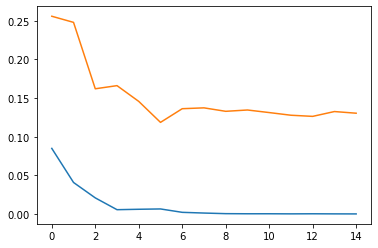

In [29]:
train_loss_per_epoch = model.history.history['loss']
valid_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(train_loss_per_epoch)), train_loss_per_epoch, valid_loss_per_epoch)

In [30]:
# split x for test

x_test = test.drop(y_col, axis=1).copy()

test_generator = TimeseriesGenerator(x_test, np.zeros(test[y_col].shape), length = n_input_train, batch_size = b_size_train)
print(test_generator[0][0].shape)


(26, 14, 18)


In [31]:
y_pred_es_scaled = model.predict(test_generator)

In [32]:
# descale & desmooth forecast

placehold_df = df.copy()
placehold_df[y_col[0]][train.shape[0] + valid.shape[0] + n_input_train:] = y_pred_es_scaled[:, 0]
placehold_df[y_col[1]][train.shape[0] + valid.shape[0] + n_input_train:] = y_pred_es_scaled[:, 1]
placehold_df = placehold_df.values + df_trend + df_seas #desmooth
placehold_df.columns = df.columns

placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns) #descale


y_pred = placehold_df[y_col][train.shape[0] + valid.shape[0] + n_input_train:]

#results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
results = pd.DataFrame({'y_true0':df[y_col[0]][train.shape[0] + valid.shape[0] + n_input_train:].values,
                        'y_true1':df[y_col[1]][train.shape[0] + valid.shape[0] + n_input_train:].values,
                        'y_pred0':y_pred.iloc[:, 0], 'y_pred1':y_pred.iloc[:, 1]})
print(results)

      y_true0    y_true1        y_pred0       y_pred1
513  128364.0  4748644.0  124818.536447  4.396183e+06
514  128367.0  4771367.0  124991.190229  4.404221e+06
515  128390.0  4791628.0  125198.378763  4.416094e+06
516  128404.0  4817298.0  125386.536390  4.424638e+06
517  128426.0  4844944.0  125535.944674  4.433050e+06
518  128453.0  4871807.0  125640.139212  4.440955e+06
519  128471.0  4896272.0  125708.722449  4.448933e+06
520  128486.0  4920168.0  125725.689436  4.455689e+06
521  128495.0  4947274.0  125728.652937  4.462997e+06
522  128532.0  4975903.0  125730.015680  4.470421e+06
523  128565.0  5007964.0  125726.501200  4.477890e+06
524  128601.0  5040060.0  125711.781995  4.483835e+06
525  128631.0  5075945.0  125666.403393  4.488648e+06
526  128665.0  5107780.0  125641.342572  4.495489e+06
527  128691.0  5139162.0  125613.536991  4.501173e+06
528  128697.0  5173972.0  125607.817161  4.507925e+06
529  128747.0  5210472.0  125618.310042  4.515485e+06
530  128797.0  5252655.0  12

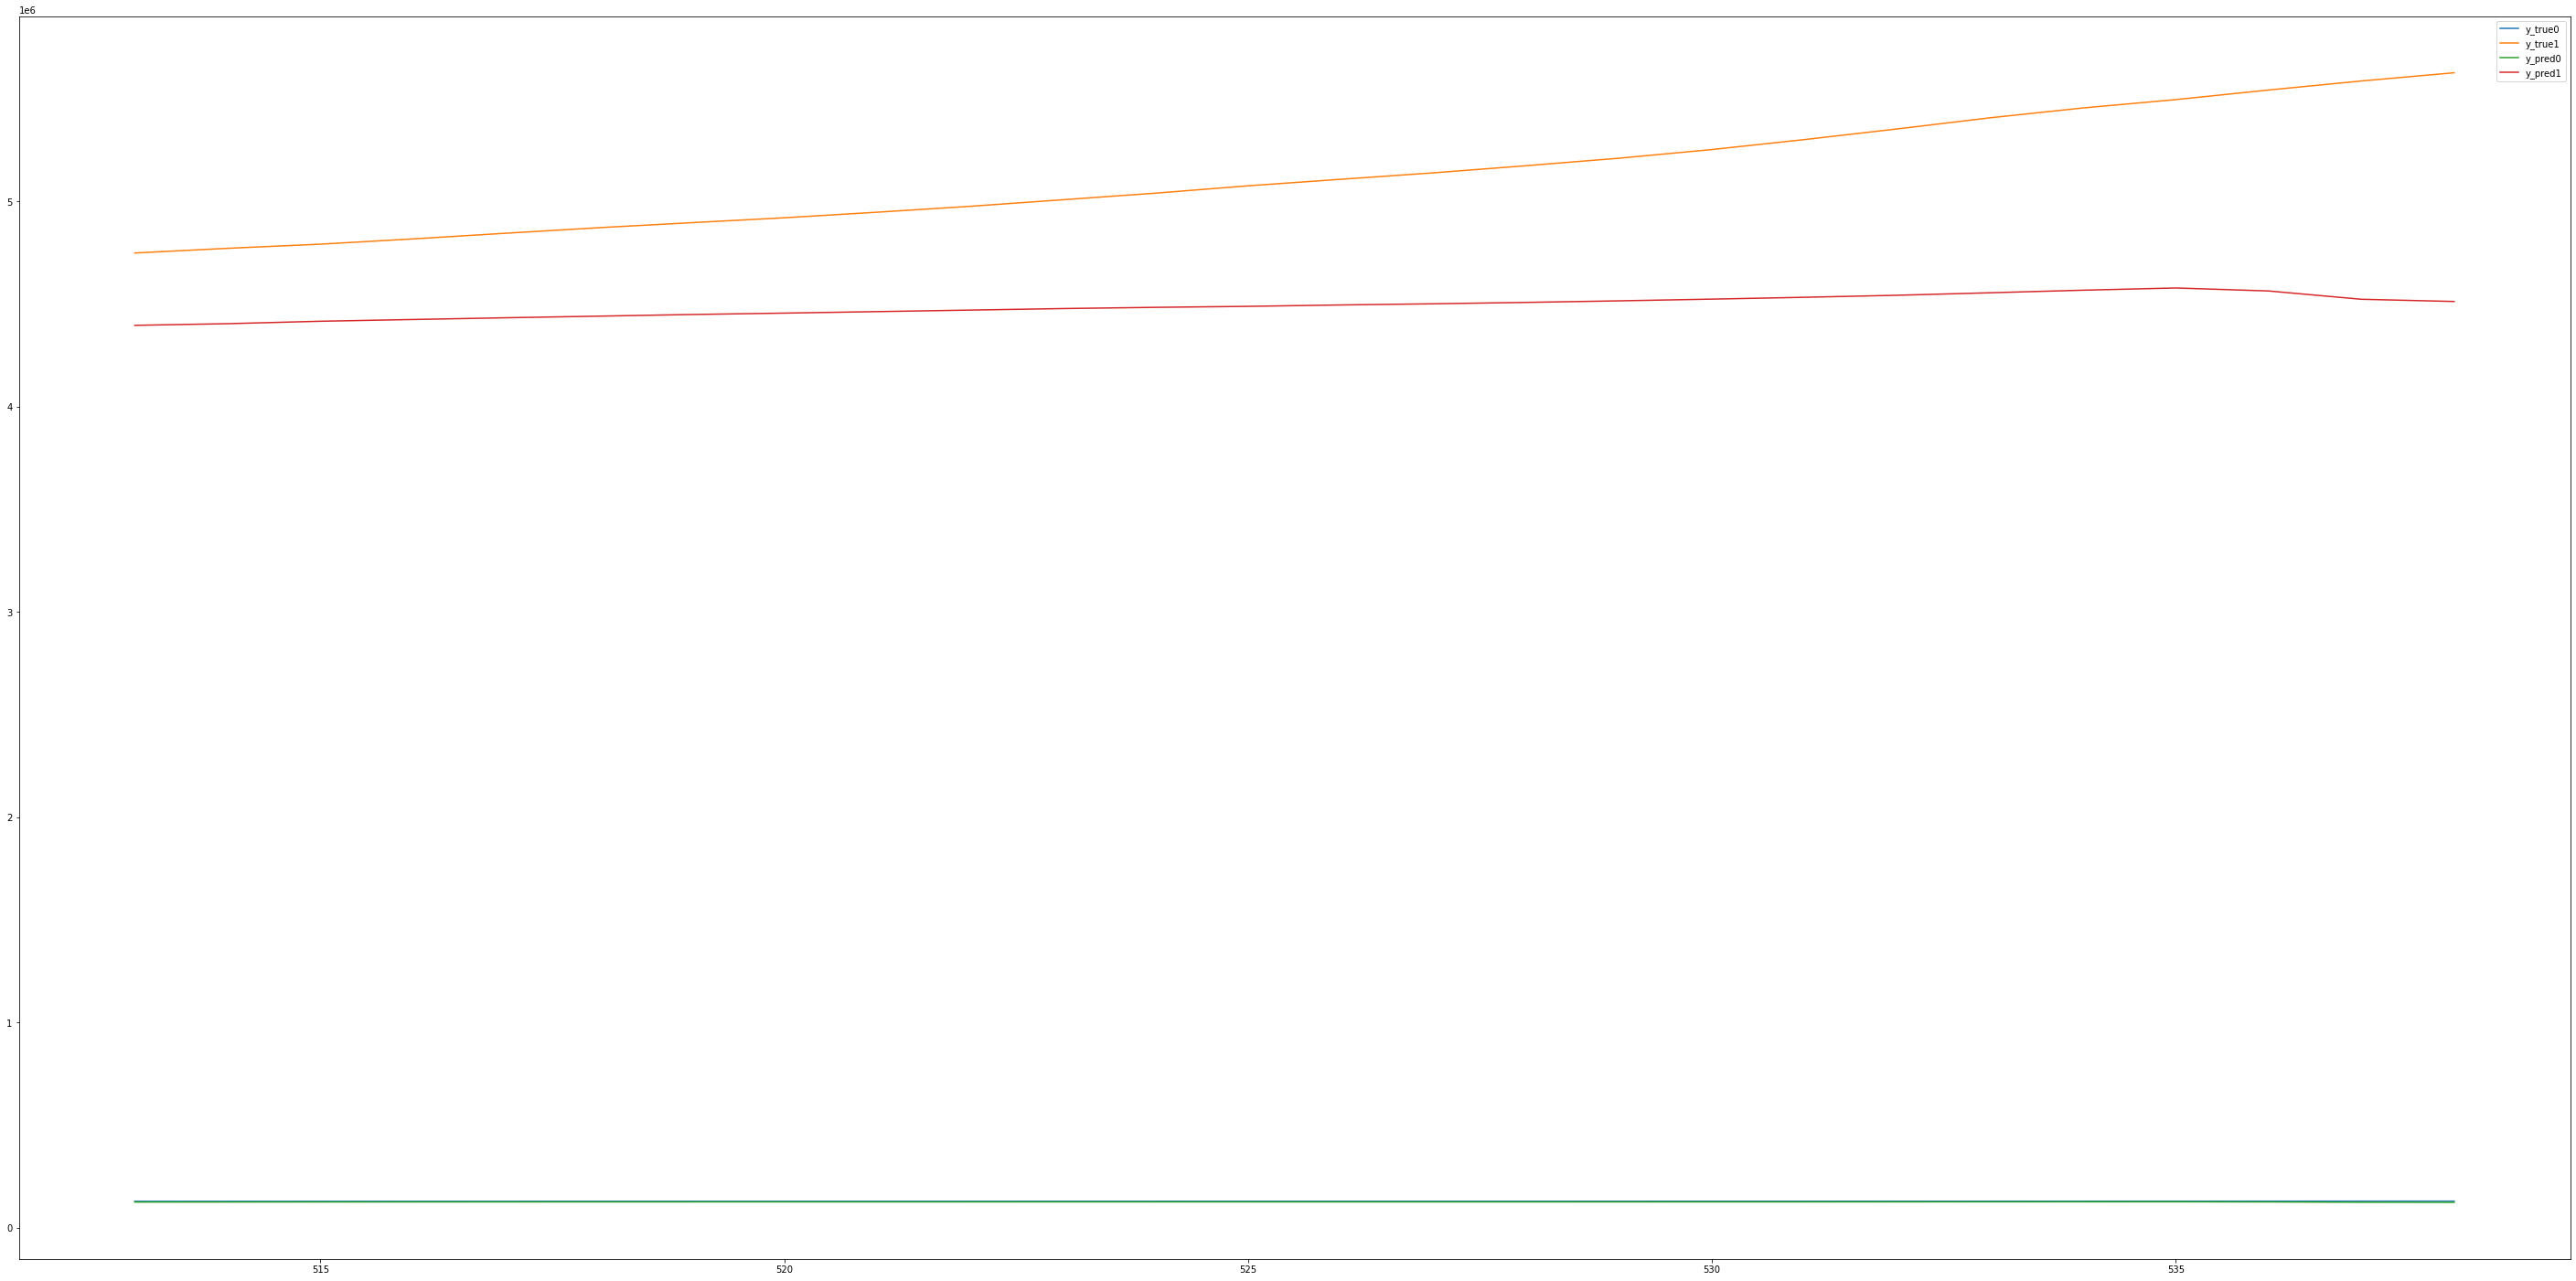

In [33]:
results.plot(figsize=(50,25))

In [34]:
print(smape(results.iloc[:, 0], results.iloc[:, 2]))
print(smape(results.iloc[:, 1], results.iloc[:, 3]))

2.548105689728997
13.17363960560696


In [35]:
print(mase(train, results.iloc[:, 0], results.iloc[:, 2]))
print(mase(train, results.iloc[:, 1], results.iloc[:, 3]))

520.5549612952267
102930.3319252714


### prediction intervals

In [36]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (n_input_train, n_features_train)))
model.add(tfp.layers.DenseFlipout(2))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               101400    
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 2)                 602       
Total params: 102,002
Trainable params: 102,002
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
15/15 [==============================] - 2s 31ms/step - loss: 758.1917 - val_loss: 755.9357
Epoch 2/15
15/15 [==============================] - 0s 16ms/step - loss: 753.5153 - val_loss: 751.4570
Epoch 3/15
15/15 [==============================] - 0s 18ms/step - loss: 748.8901 - val_loss: 746.6360
Epoch 4/15
15/15 [==============================] - 0s 17ms/step - loss: 744.3139 - val_loss: 742.3414
Epoch 5/15
15/15 [==============================] - 0s 17ms/step - loss: 739.7847 - val_loss: 737.6739
Epoch 6/15
15/15 [==============================] - 0s 18ms/step - loss: 735.3432 - val_loss: 733.2856
Epoch 7/15
15/15 [==============================] - 0s 17ms/step - loss: 730.9049 - val_loss: 728.7856
Epoch 8/15
15/15 [==============================] - 0s 16ms/step - loss: 726.4327 - val_loss: 724.5115
Epoch 9/15
15/15 [==============================] - 0s 17ms/step - loss: 722.0162 - val_loss: 720.1447
Epoch 10/15
15/15 [==============================] - 0s 18ms/step - loss:

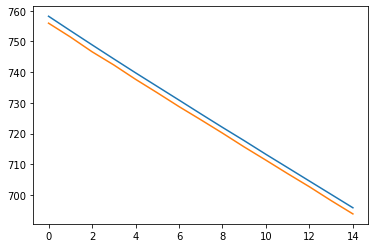

In [37]:
epochs = 15
model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs)

train_loss_per_epoch = model.history.history['loss']
valid_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(train_loss_per_epoch)), train_loss_per_epoch, valid_loss_per_epoch)

In [38]:
runs = 100

df_low = pd.DataFrame()
df_up = pd.DataFrame()

for run in range(runs):
    y_pred_scaled = pd.DataFrame(model.predict(test_generator))
    df_low = df_low.append(y_pred_scaled.iloc[:, 0])
    df_up = df_up.append(y_pred_scaled.iloc[:, 1])

In [39]:
alpha = 0.05 
lower_q = alpha/2
lower_0 = np.quantile(df_low, lower_q, axis = 0)
lower_1 = np.quantile(df_up, lower_q, axis = 0)
upper_q = 1 - alpha + alpha/2
upper_0 = np.quantile(df_low, upper_q, axis = 0)
upper_1 = np.quantile(df_up, upper_q, axis = 0)

In [40]:
lower_0.shape

(26,)

In [41]:
upper_0

array([1.19543699, 1.23207198, 1.26615274, 1.3241691 , 1.29191003,
       1.31377626, 1.36424795, 1.41380222, 1.2988231 , 1.48629447,
       1.37095262, 1.34028011, 1.4409619 , 1.37606139, 1.37745277,
       1.33280382, 1.37105072, 1.49473213, 1.3530824 , 1.24648708,
       1.3594927 , 1.34211978, 1.31244286, 1.23179977, 1.38671272,
       1.32414137])

In [42]:
# descale & desmooth lower

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = lower_0
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = lower_1
placehold_df = placehold_df.values + df_trend + df_seas # desmooth
placehold_df.columns = df.columns
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns) # descale
lower = placehold_df[y_col][-y_pred_scaled.shape[0]:]

# descale & desmooth upper

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = upper_0
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = upper_1
placehold_df = placehold_df.values + df_trend + df_seas # desmooth
placehold_df.columns = df.columns
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns) # descale
upper = placehold_df[y_col][-y_pred_scaled.shape[0]:]

In [43]:
print(mis(lower.iloc[:, 0].values, upper.iloc[:, 0].values, results.iloc[:, 0].values, alpha = alpha))
print(mis(lower.iloc[:, 1].values, upper.iloc[:, 1].values, results.iloc[:, 1].values, alpha = alpha))

131952.66748908546
5541167.726594748


In [44]:
print(coverage(lower.iloc[:, 0].values, upper.iloc[:, 0].values, results.iloc[:, 0].values))
print(coverage(lower.iloc[:, 1].values, upper.iloc[:, 1].values, results.iloc[:, 1].values))

100.0
100.0


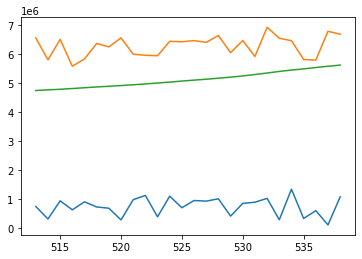

In [45]:
import matplotlib
matplotlib.pyplot.plot(lower.iloc[:, 1])
matplotlib.pyplot.plot(upper.iloc[:, 1])
matplotlib.pyplot.plot(results.iloc[:, 1])

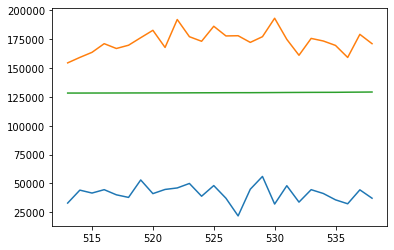

In [46]:
import matplotlib
matplotlib.pyplot.plot(lower.iloc[:, 0])
matplotlib.pyplot.plot(upper.iloc[:, 0])
matplotlib.pyplot.plot(results.iloc[:, 0])